<a href="https://colab.research.google.com/github/ccwu0918/MathProgramming/blob/main/Chapter4/Chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4章 了解解決最佳化問題的流程
本章將透過旅行業務員問題介紹最佳化的基本思維。

## 4-3. 執行窮舉式演算法

倉庫的座標
[[ 9 25]
 [68 88]
 [80 49]
 [11 95]
 [53 99]
 [54 67]
 [99 15]
 [35 25]]
倉庫的相對位置


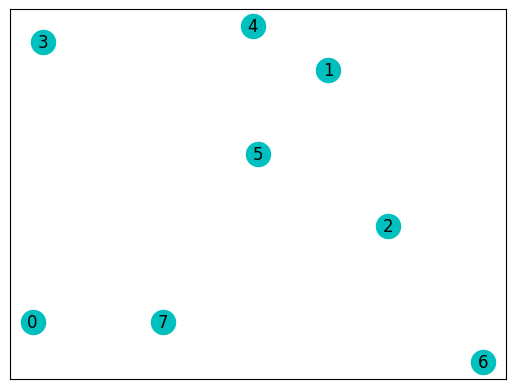

In [1]:
import numpy as np
np.random.seed(100)
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# 將頂點數設定為8
n = 8

# 載入各地點的座標
vertices = pd.read_csv('vertices.csv').values
print('倉庫的座標')
print(vertices)

# 繪製圖表
g = nx.DiGraph()

# 在圖表追加n個頂點
g.add_nodes_from(range(n))

# 將頂點座標的相關資訊整理成容易新增至圖表的格式
pos = dict(enumerate(zip(vertices[:, 0], vertices[:, 1])))

# 繪製圖表
nx.draw_networkx(g, pos=pos, node_color='c')
print('倉庫的相對位置')
plt.show()

### 計算距離

In [2]:
# 以矩陣呈現頂點之間的距離
graph = np.linalg.norm(
    vertices[:, None] - vertices[None, :],
    axis=-1,
)
# graph(5, 3) 代表從頂點5到頂點3的距離
# graph(0, 7) 代表從頂點0到頂點7的距離

# 為了方便計算，無條件捨去小數點
graph = graph.astype(int)

print('代表倉庫間距離的矩陣')
print(graph)

代表倉庫間距離的矩陣
[[  0  86  74  70  86  61  90  26]
 [ 86   0  40  57  18  25  79  71]
 [ 74  40   0  82  56  31  38  51]
 [ 70  57  82   0  42  51 118  74]
 [ 86  18  56  42   0  32  95  76]
 [ 61  25  31  51  32   0  68  46]
 [ 90  79  38 118  95  68   0  64]
 [ 26  71  51  74  76  46  64   0]]


In [3]:
from itertools import permutations

# 決定起點(終點)
src = 0

# 找出所有路線(除了起點之外)
routes = np.array([*permutations(range(1, 8))]).T

# 輸出路線數
m = routes.shape[1]
print(f'路線數: {m}')

# 在開頭與結束追加起點
routes = np.pad(routes, pad_width=((1,1), (0,0)), constant_values=src)
print('列舉所有路線')
print(routes)

# 算出每條路線的總移動距離
dist = graph[routes[:-1], routes[1:]].sum(axis=0)
print('每條路線的總移動距離')
print(dist)

路線數: 5040
列舉所有路線
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 7 7 7]
 [2 2 2 ... 6 6 6]
 ...
 [6 7 5 ... 3 1 2]
 [7 6 7 ... 1 2 1]
 [0 0 0 ... 0 0 0]]
每條路線的總移動距離
[440 482 485 ... 471 403 440]


In [4]:
print(f'最短距離: {dist.min()}')

最短距離: 314


In [5]:
# 根據由小至大的移動距離排序路線
i = np.argsort(dist)
routes = routes[:, i]
dist = dist[i]
print('根據由小至大的移動距離排序路線')
print(dist)

path = routes[:, 0]
print(f'最短路線: {path}')
print(f'最短距離: {dist[0]}')

根據由小至大的移動距離排序路線
[314 314 336 ... 618 620 620]
最短路線: [0 3 4 1 5 2 6 7 0]
最短距離: 314


### 繪製移動距離最短的巡迴路線

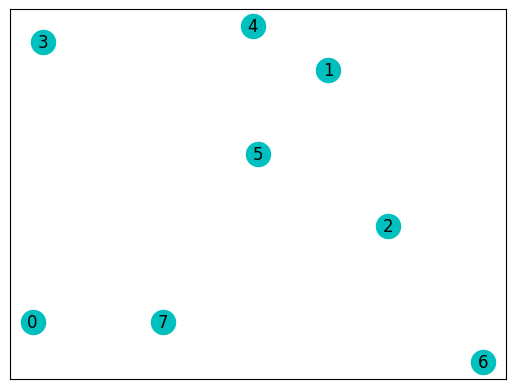

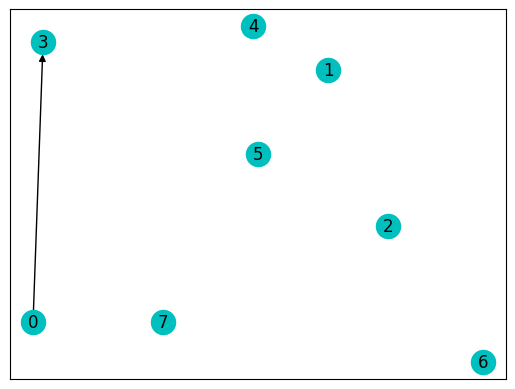

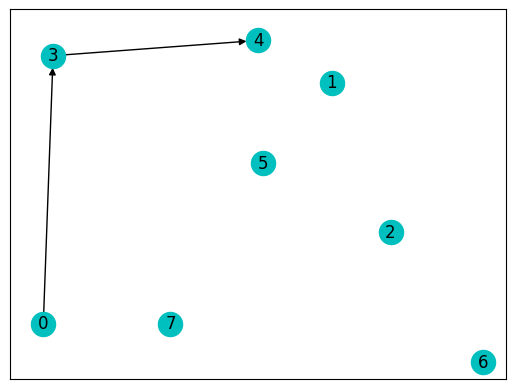

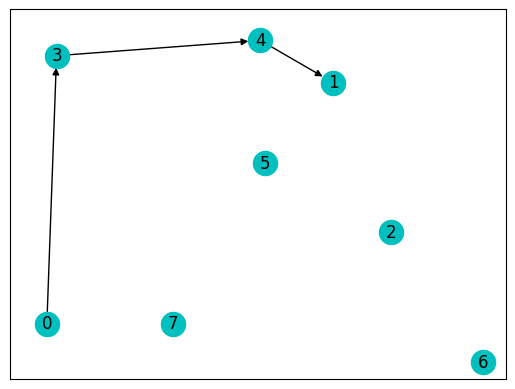

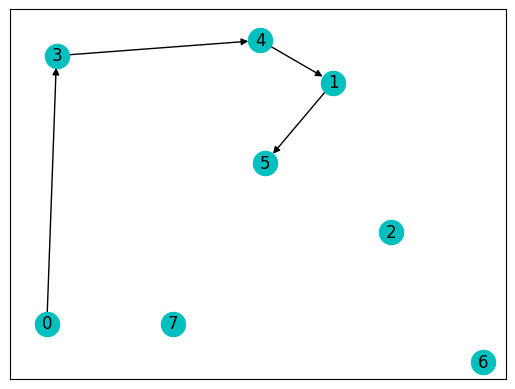

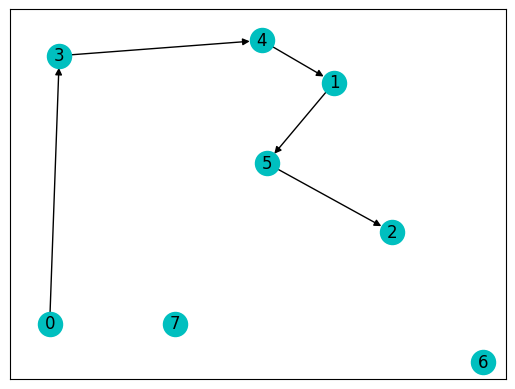

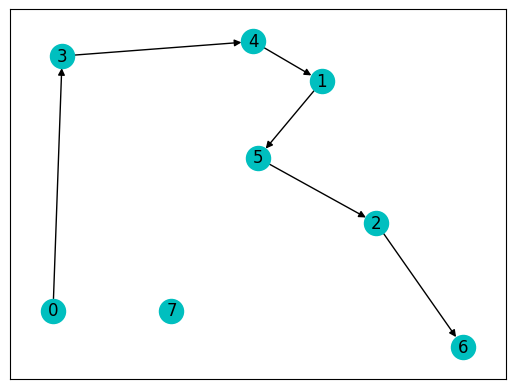

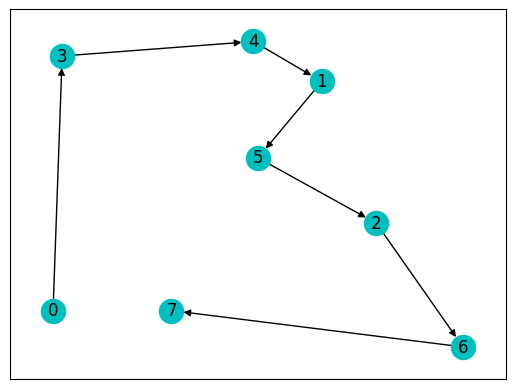

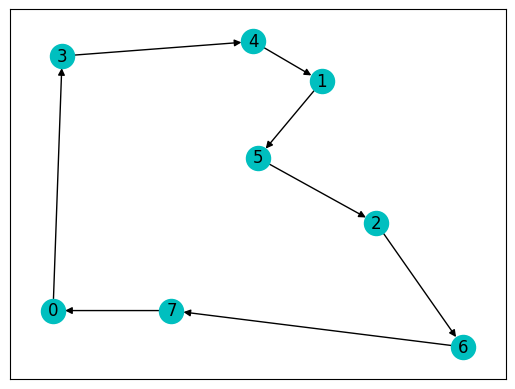

In [6]:
for i in range(n):
    nx.draw_networkx(g, pos=pos, node_color='c')
    plt.show()
    g.add_edge(path[i], path[i+1])
nx.draw_networkx(g, pos=pos, node_color='c')
plt.show()


for i in range(n):
    g.remove_edge(path[i], path[i+1])

## 4-4. 了解利用演算法解決問題的方法

### 利用for迴圈算出總和

In [7]:
# 將n設定為100
n = 100
s = sum(i for i in range(1, n+1))
print(f'總和: {s}')

總和: 5050


### 利用總和的公式計算

In [8]:
n = 10
s = (1+n)*n//2
print(f'總和: {s}')

總和: 55


### n放大的情況

In [9]:
n = 10000
s = (1+n)*n//2
print(f'總和: {s}')

總和: 50005000


## 4-6. 了解動態規劃法的程式碼

### Graph類別

In [10]:
from itertools import combinations
import pandas as pd
import random
inf = float('inf')

class Graph:
    class Edge:
        def __init__(self, weight=1, **args):
            self.weight = weight

        def __repr__(self):
            return f'{self.weight}'


    def __init__(self, n):
        self.N = n
        self.edges = [{} for _ in range(n)]


    # 追加邊
    def add_edge(self, u, v, **args):
        self.edges[u][v] = self.Edge(**args)


    @classmethod
    def from_csv(cls, path):
        nodes = pd.read_csv(path).values
        n = nodes.shape[0]
        print(f'頂点數: {n}')
        weights = cls.weights_from_nodes(nodes)

        g = cls(n)
        g.generate_network(nodes)

        for u in range(n):
            for v in range(n):
                g.add_edge(u, v, weight=weights[u, v])
        return  g


    @staticmethod
    def generate_nodes(n):
        nodes = np.random.randint(low=0, high=100, size=(n, 2))
        return nodes


    def generate_network(self, nodes):
        n = len(nodes)
        network = nx.DiGraph()
        network.add_nodes_from(range(n))
        pos = dict(
            enumerate(zip(nodes[:, 0], nodes[:, 1]))
        )
        nx.draw_networkx(network, pos=pos, node_color='c')
        self.network = network
        self.pos = pos
        return network


    @staticmethod
    def weights_from_nodes(nodes):
        return np.linalg.norm(
            nodes[:, None] - nodes[None, :],
            axis=-1,
        ).astype(np.int64)


    # 隨機產生邊的函數(若需要建立csv以外的模式可以使用這個函數)
    def generate_edges(self):
        random.seed(0)
        for u, v in combinations(range(self.N), 2):
            weight = random.randint(1, 100)
            self.add_edge(u, v, weight=weight)
            self.add_edge(v, u, weight=weight)
        for u in range(self.N):
            self.add_edge(u, u, weight=0)


    # 計算路線的總移動距離(窮舉法)
    def calculate_dist(self, route):
        n = self.N
        source = route[0]
        route += [source]
        return sum(
            self.edges[route[i]][route[i+1]].weight
            for i in range(n)
        )


    def show_path(self, path):
        n = self.N
        network = self.network
        pos = self.pos
        for i in range(n):
            network.add_edge(path[i], path[i+1])
        nx.draw_networkx(
            network,
            pos=pos,
            node_color='c',
        )
        plt.show()
        self.remove_edges()


    def remove_edges(self):
        network = self.network
        network.remove_edges_from(
            list(network.edges)
        )




In [11]:
class TSPBruteForce(Graph):
    # 窮舉式演算法(用來與DP演算法比較，不會使用numpy撰寫相關的程式碼)
    def __call__(self, src=0):
        n = self.N
        stack = [([src], 1<<src)]
        dist = float('inf')
        calc_count = 0
        while stack:
            route, visited = stack.pop()
            if visited == (1<<n) - 1:
                calc_count += 1
                d = self.calculate_dist(route)
                if d >= dist: continue
                dist = d
                res_route = route

            for i in range(n):
                if i==src or visited>>i & 1: continue
                nxt_route = route.copy()
                nxt_route.append(i)
                stack.append((nxt_route, visited|(1<<i)))

        print(f'計算次數: {calc_count}')
        return dist, res_route

In [12]:
class TSPDP(Graph):
    # DP演算法
    def __call__(self, src=0):
        n = self.N
        dp = [[(inf, None)] * n for _ in range(1<<n)]
        dp[1][src] = (0, None)
        calc_count = 0
        for s in range(1<<n):
            for v in range(n):
                if s>>v&1: continue
                t = s|(1<<v) # t是在s追加v的集合
                for u in range(n):
                    if ~s>>u&1: continue
                    d = dp[s][u][0] + self.edges[u][v].weight
                    if d >= dp[t][v][0]:
                        continue
                    dp[t][v] = (d, u)
                    calc_count += 1

        print(f'計算次數: {calc_count}')

        dist = inf
        predecessor = []
        for u in range(1, n):
            s = (1 << n) - 1
            d = dp[s][u][0] + self.edges[u][src].weight
            if d >= dist: continue
            dist = d
            predecessor = [src]
            while True:
                v = u
                predecessor.append(v)
                u = dp[s][v][1]
                if u is None: break
                s &= ~(1 << v)

        return dist, predecessor[::-1]

### 根據csv產生圖表Graph

DP
頂点數: 11
窮舉式
頂点數: 11


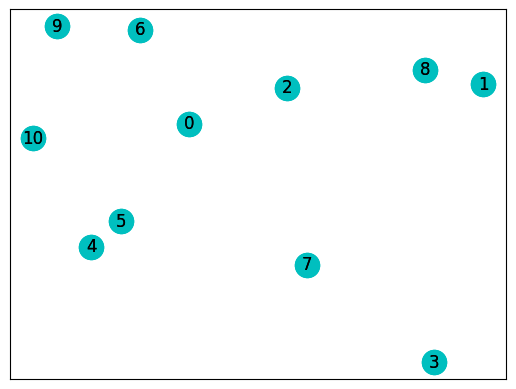

In [13]:
print('DP')
g1 = TSPDP.from_csv('4_6_nodes.csv')
print('窮舉式')
g2 = TSPBruteForce.from_csv('4_6_nodes.csv')

### 利用DP算出距離與路線（path）

In [14]:
%%time
d, path = g1(src=0)
print(f'距離: {d}')
print(f'路線: {path}')

計算次數: 10633
距離: 331
路線: [0, 6, 9, 10, 4, 5, 7, 3, 1, 8, 2, 0]
CPU times: total: 15.6 ms
Wall time: 123 ms


### 利用窮舉法計算距離與路線path

In [15]:
%%time
d, path = g2(src=0)
print(f'距離: {d}')
print(f'路線: {path}')

計算次數: 3628800
距離: 331
路線: [0, 6, 9, 10, 4, 5, 7, 3, 1, 8, 2, 0]
CPU times: total: 9.45 s
Wall time: 25.4 s


### 可視化路線path

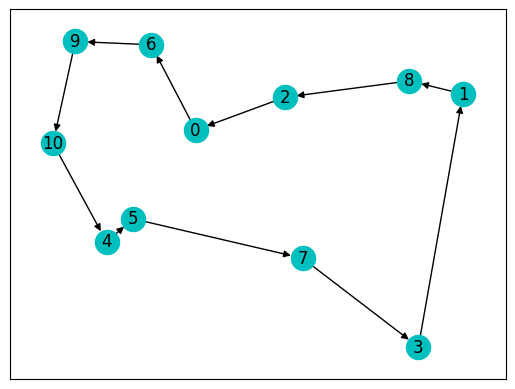

In [16]:
g2.show_path(path)

## 4-8. 利用最近鄰居法求出近似解

### 最用最近鄰居法解決TSP的類別

In [17]:
class TSPNearestNeighbour(Graph):
    def __call__(self, src=0):
        n = self.N
        visited = [False] * n
        visited[0] = True
        dist = 0
        u = src # 前一個頂點
        path = [src]
        calc_count = 0
        for _ in range(n-1):
            cand = []
            for v in range(n): # 下一個前往的頂點
                calc_count += 1
                if visited[v]: continue
                cand.append((v, dist + self.edges[u][v].weight))

            cand.sort(key=lambda x: x[1])
            u, dist = cand[0] # 前往距離最近的頂點
            visited[u] = True
            path.append(u)
        path.append(src)
        print(f'計算次數: {calc_count}')

        return dist + self.edges[u][src].weight, path

### 從csv載入Graph

最近鄰居法
頂点數: 18
DP
頂点數: 18


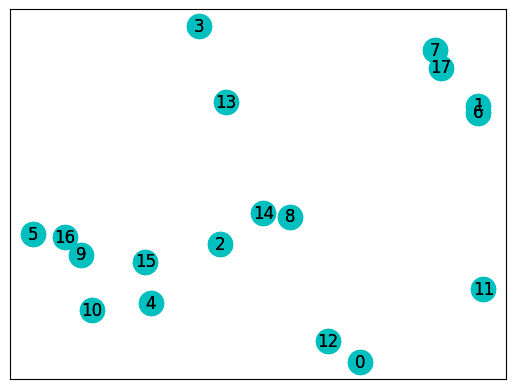

In [18]:
print('最近鄰居法')
g = TSPNearestNeighbour.from_csv('4_8_nodes.csv')
print('DP')
g2 = TSPDP.from_csv('4_8_nodes.csv')

### 利用最近鄰居法計算最短路徑

計算次數: 306
距離: 375
路線: [0, 12, 11, 8, 14, 2, 15, 4, 10, 9, 16, 5, 13, 3, 7, 17, 1, 6, 0]


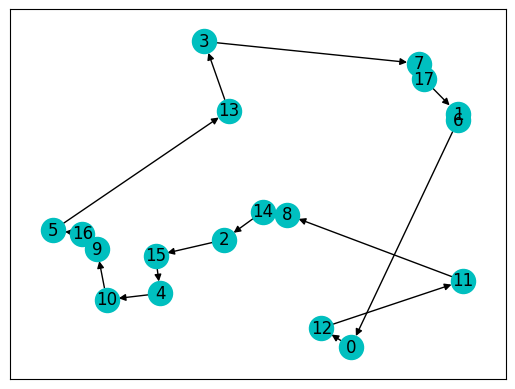

CPU times: total: 31.2 ms
Wall time: 195 ms


In [19]:
%%time
d, path = g(src=0)
print(f'距離: {d}')
print(f'路線: {path}')
g.show_path(path)

### 利用動態規劃法（DP）找出最短路徑

計算次數: 2782671
距離: 334
路線: [0, 12, 4, 10, 5, 16, 9, 15, 2, 14, 8, 13, 3, 7, 17, 1, 6, 11, 0]


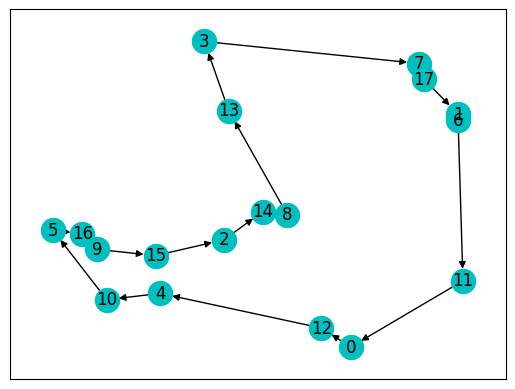

CPU times: total: 13.6 s
Wall time: 37.9 s


In [20]:
%%time
d2, path = g2(src=0)
print(f'距離: {d2}')
print(f'路線: {path}')
g.show_path(path)

### 計算距離的相對誤差

In [21]:
print(f'相對誤差: {(d-d2)/d2}')

相對誤差: 0.12275449101796407


### 可視化最近鄰居法的搜尋過程

倉庫的相對位置


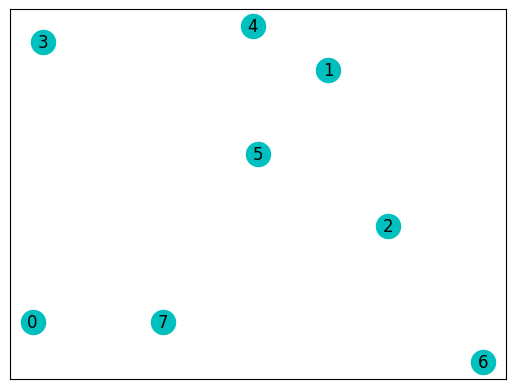

In [22]:
import numpy as np
np.random.seed(100)
import networkx as nx
import matplotlib.pyplot as plt

n = 8
vertices = np.random.randint(1, 100, (n, 2))
g = nx.DiGraph()
g.add_nodes_from(range(n))
pos = dict(enumerate(zip(vertices[:, 0], vertices[:, 1])))
print('倉庫的相對位置')
nx.draw_networkx(g, pos=pos, node_color='c')
plt.show()

In [23]:
dist = vertices[:,None] - vertices[None, :]
dist = np.sqrt((dist**2).sum(axis=-1)).astype(int)
print('倉庫間距離的矩陣')
print(dist)

graph = TSPNearestNeighbour(n)
for i in range(n):
    for j in range(n):
        graph.add_edge(i, j, weight=dist[i,j])

倉庫間距離的矩陣
[[  0  86  74  70  86  61  90  26]
 [ 86   0  40  57  18  25  79  71]
 [ 74  40   0  82  56  31  38  51]
 [ 70  57  82   0  42  51 118  74]
 [ 86  18  56  42   0  32  95  76]
 [ 61  25  31  51  32   0  68  46]
 [ 90  79  38 118  95  68   0  64]
 [ 26  71  51  74  76  46  64   0]]


計算次數: 56


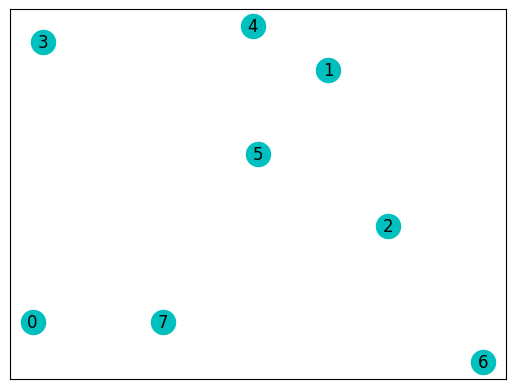

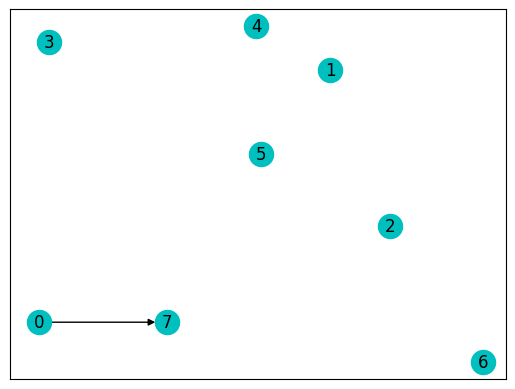

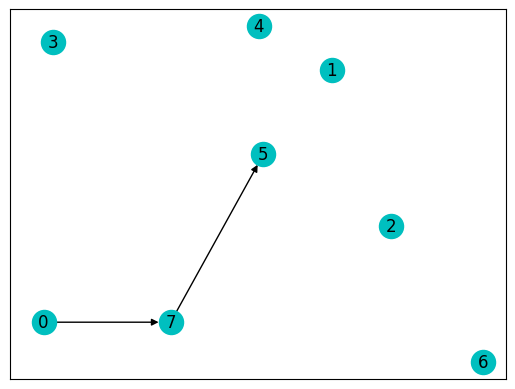

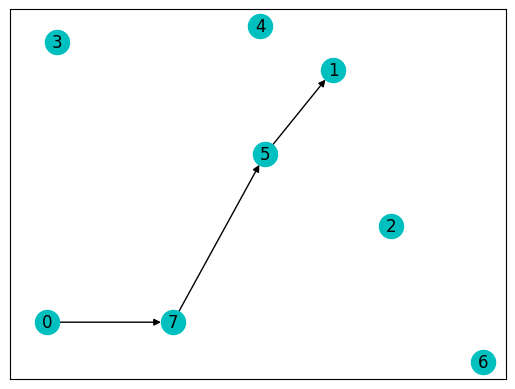

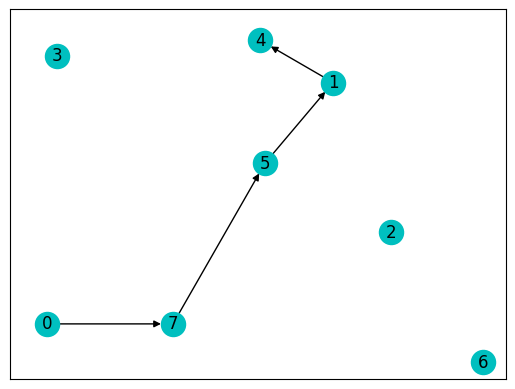

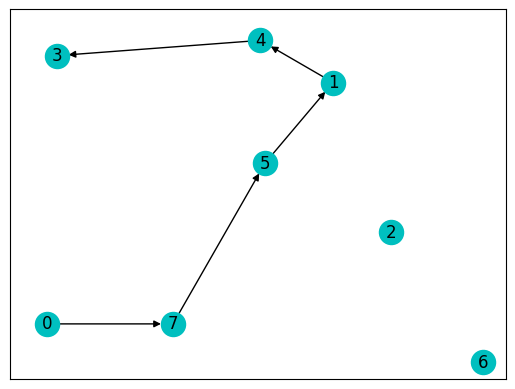

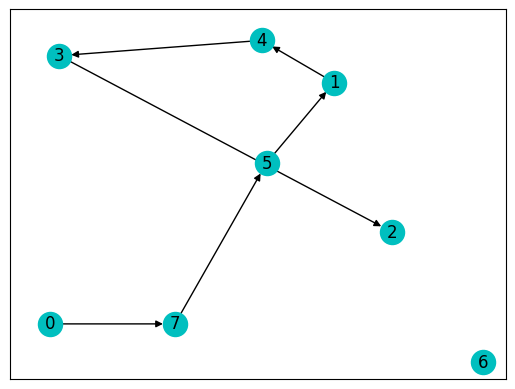

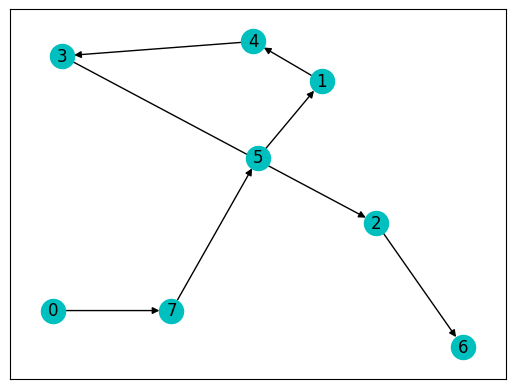

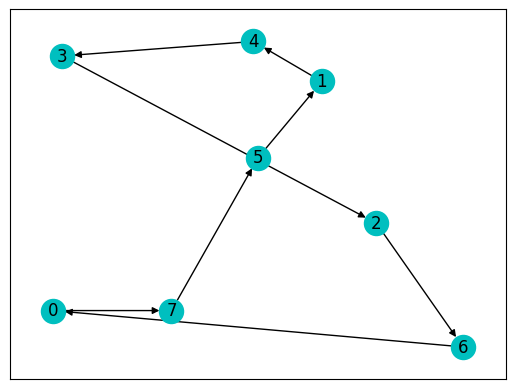

In [24]:
d, path = graph(src=0)
n = len(path) - 1
for i in range(n):

    nx.draw_networkx(g, pos=pos, node_color='c')
    plt.show()
    g.add_edge(path[i], path[i+1])
nx.draw_networkx(g, pos=pos, node_color='c')
plt.show()

for i in range(n):
    g.remove_edge(path[i], path[i+1])


## 4-9. 利用基因演算法學習計算近似解的方法

In [25]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

### 利用GA解決TSP的類別

In [26]:
# 這次為了方便起見，將起點與終點固定為0。
class GATSP:
    def __init__(self, n=10):
        self.N = n

    def generate_nodes(self):
        np.random.seed(0)
        self.nodes = np.random.uniform(size=(self.N, 2))
        self._dist = np.linalg.norm(
            self.nodes[:,None] - self.nodes[None,:],
            axis=-1,
        )


    @classmethod
    def from_csv(cls, path):
        nodes = pd.read_csv(path).values
        n = nodes.shape[0]
        tsp = cls(n)
        tsp._dist = np.linalg.norm(
            nodes[:,None] - nodes[None,:],
            axis=-1,
        )
        tsp.nodes = nodes
        return tsp


    def generate_route(self):
        return np.random.permutation(np.arange(1, self.N))

    @staticmethod
    def routes_from_csv(path):
        routes = pd.read_csv(path).values
        return routes


    def init_routes(self, m=100):
        routes = np.array([self.generate_route() for _ in range(m)])
        return np.pad(routes, pad_width=((0,0), (1,0)), constant_values=0)


    def dist(self,routes):
        routes = np.pad(routes, pad_width=((0,0), (0,1)), constant_values=0)
        return self._dist[routes[:,:-1],routes[:,1:]].sum(axis=1)


    def fitness(self, routes): return 1/self.dist(routes)


    def select_parents(self, routes, m=None):
        if m is None: m = routes.shape[0]//2
        assert 2*m <= routes.shape[0]
        f = self.fitness(routes)
        p = f/f.sum()
        pair = np.random.choice(routes.shape[0], (m, 2), replace=True, p=p)
        i = np.argsort(routes, axis=1)
        return routes[pair], i[pair]

    def crossover(self, routes, m=None):
        if m is None: m = routes.shape[0]//2
        parents, i = self.select_parents(routes, m)
        for j in range(m): # 讓每對互換
            k = np.random.randint(1,self.N-1)
            parents[j,np.arange(2),i[j,np.arange(2),parents[j,::-1,k]]], parents[j,:,k] \
            = parents[j,:,k], parents[j,np.arange(2),i[j,np.arange(2),parents[j,::-1,k]]]
        childs = parents.reshape(-1, self.N)
        return childs

    def mutate(self, routes, p=0.7):
        m = routes.shape[0]
        bl = np.random.choice((0,1), m, replace=True, p=(1-p, p)).astype(bool) #指定發生突變的機率
        k = np.arange(m)[bl]
        i, j = np.random.randint(1, self.N-1, (m, 2))[bl].T
        routes[k,i], routes[k,j] = routes[k,j], routes[k,i]
        return routes


    def extract_elites(self, routes, elite_cnt):
        return routes[np.argsort(self.fitness(routes))[-elite_cnt:]]


    def generate_nxt(self, routes, elite_cnt=2):
        elites = self.extract_elites(routes, elite_cnt)
        childs = self.crossover(routes, m=(routes.shape[0]-elite_cnt)//2)
        childs = self.mutate(childs)
        return np.vstack([elites, childs])


    def show(self, routes):
        path = list(routes[np.argsort(tsp.dist(routes))][0])+[0]
        plt.figure(figsize=(15,10))
        g = nx.DiGraph()
        g.add_nodes_from(range(n))
        pos = dict(enumerate(zip(tsp.nodes[:, 0], tsp.nodes[:, 1])))
        nx.draw_networkx(g, pos=pos, node_color='c')
        for i in range(len(path)-1):
            g.add_edge(path[i], path[i+1])
        nx.draw_networkx(g, pos=pos, node_color='c')
        plt.show()
        plt.clf()


### 從csv載入倉庫(nodes)的座標，產生求解器實體

In [27]:
tsp = GATSP.from_csv('4_10_nodes.csv')
n = len(tsp.nodes)
routes = tsp.routes_from_csv('4_10_routes.csv')
print('第0世代的路徑群')
print(routes)

第0世代的路徑群
[[ 0  4 16 ... 11 18  6]
 [ 0  3 17 ... 18 19 16]
 [ 0 11 19 ...  4 13  5]
 ...
 [ 0  1  9 ... 19 17 12]
 [ 0 17 13 ... 19  4  2]
 [ 0  9 11 ...  3  5  7]]


### 執行基因演算法
每1000世代輸出一次最短路徑

第0世代


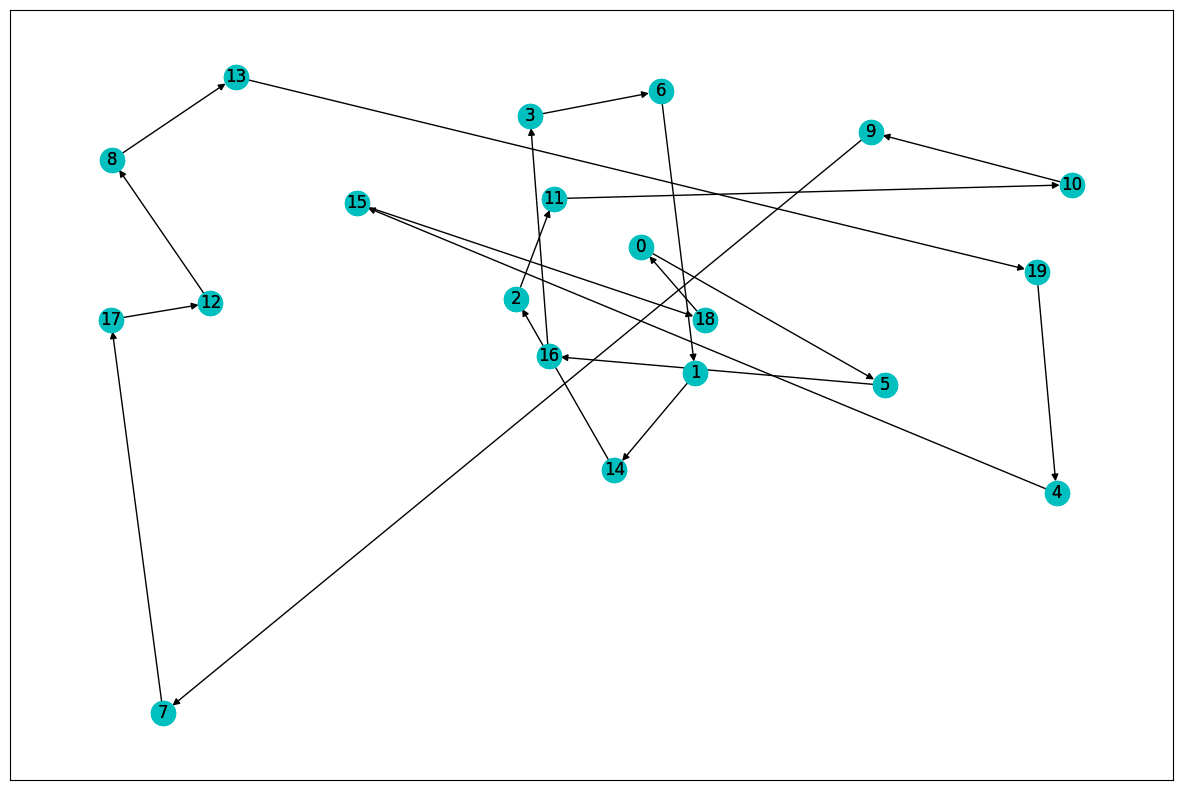

第1000世代


<Figure size 640x480 with 0 Axes>

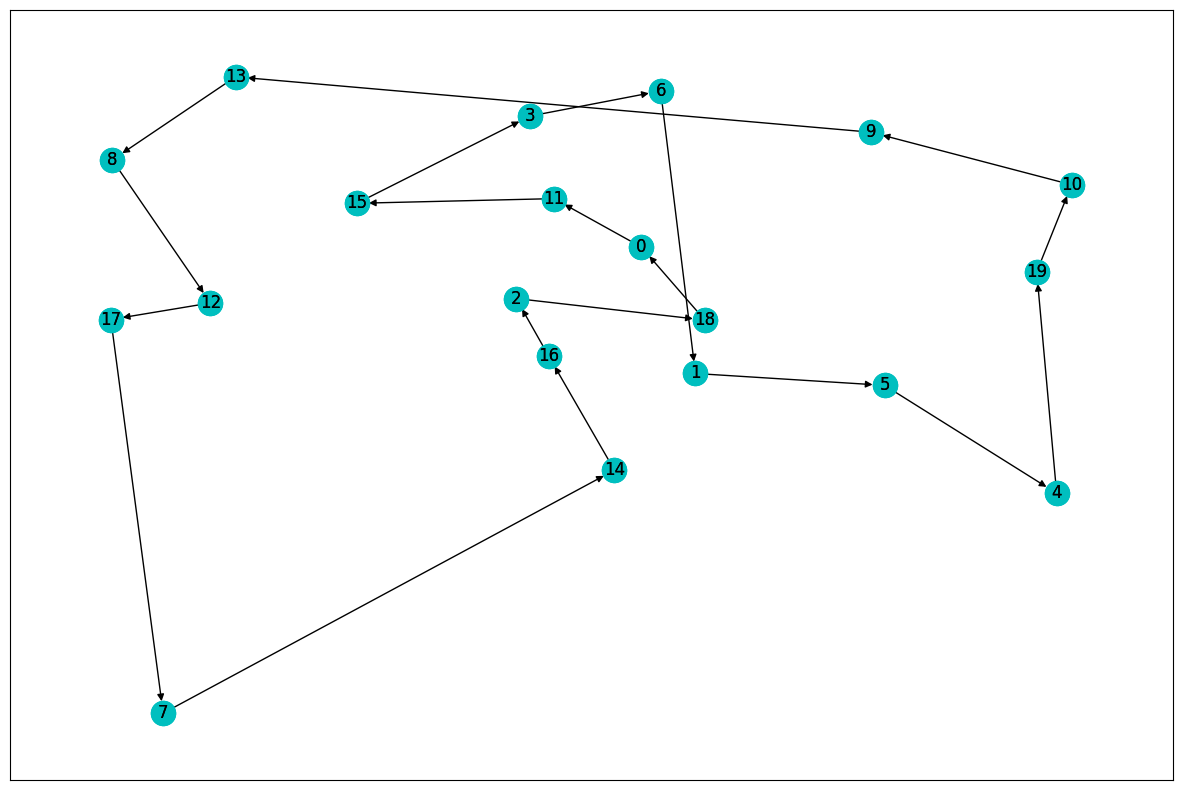

第2000世代


<Figure size 640x480 with 0 Axes>

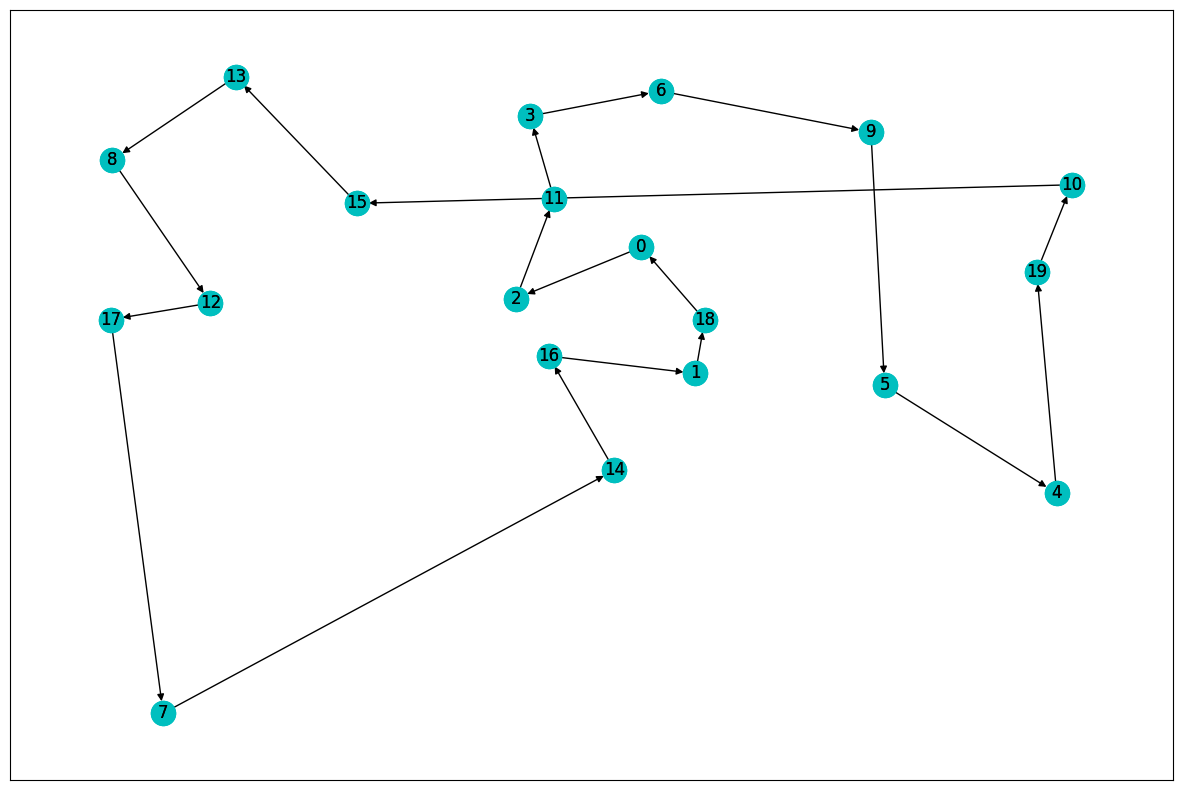

<Figure size 640x480 with 0 Axes>

In [28]:
for i in range(2001):
    routes = tsp.generate_nxt(routes)
    if i % 1000 == 0:
        print(f'第{i}世代')
        tsp.show(routes)